<a href="https://colab.research.google.com/github/OsamuDazai666/Clock-Image-Classification/blob/main/clock_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Generation

In [ ]:
!rm -rf train
!rm -rf validation
!rm -rf test

In [ ]:
!mkdir train
!mkdir validation
!mkdir test

In [ ]:
# future reminder: just run this block, don't change anything, this initializes the function to generate the dataset
import os
import math
import random
from PIL import Image, ImageDraw

from PIL import ImageDraw
def draw_clock_circle(size, num_hours, draw):
    # Calculate the angle between each hour mark
    angle_per_hour = 360 / num_hours

    # Draw the circle with gaps representing the hours
    center = (size // 2, size // 2)
    radius = size // 2 - 10  # Leave some padding from the edges
    for i in range(num_hours):
        angle = math.radians(i * angle_per_hour - 90)  # Convert to radians and shift by -90 degrees
        x1 = center[0] + radius * math.cos(angle)
        y1 = center[1] + radius * math.sin(angle)
        x2 = center[0] + (radius - 10) * math.cos(angle)
        y2 = center[1] + (radius - 10) * math.sin(angle)
        draw.line((x1, y1, x2, y2), fill='black', width=2)

def get_points(origin, radius, separation_angle=30):
    """
        orgin: cordinates of the origins,
        radius: radius of the circle,
        separation_angle: the separation angle (the angle by which to divide 360)
    """
    cordinates = []
    for i in range(0, 360 // separation_angle):
        deg_angle = (separation_angle * (i + 1)) * (3.14 / 180) #
        x = round(radius * math.cos(deg_angle))
        y = round(radius * math.sin(deg_angle))
        cordinates.append((origin[0] + x, origin[1] + y))

    return cordinates


def create_dataset(sample_size, images_per_folder, folder,
                   seed, image_size, length_hours, length_minutes):
    """
        The minutes_coordinates and hours_coordinates that we
        receive from get points are labeled acoording to PIL library.
        And Same goes for minutes and hours. Change it if you know
        what you are doing.

        sample_size: "number of iteration to perform, value between 500-1000 work better"
        images_per_folder: "number of images to generate per folder"
        folder: "name of folder to generate images in"
        seed: "random seed"
        image_size: "image height and width both must be same"
        length_hours: "length of hours hand"
        length_minutes: "length of minutes hand"
    """
    random.seed(seed)
    line_lenght = image_size // 2

    # change if you know what you are doing
    minutes = ["20", "25", "30", "35", "40", "45", "50", "55", "00", "05", "10", "15"]
    hours = ["04", "05", "06", "07", "08", "09", "10", "11", "12", "01", "02", "03"]

    minutes_cordinates = get_points((line_lenght, line_lenght), radius=length_minutes, separation_angle=30)
    hours_cordinates = get_points((line_lenght, line_lenght), radius=length_hours, separation_angle=30)

    SAMPLE_SIZE = sample_size
    random_minutes = random.choices(minutes_cordinates, k=SAMPLE_SIZE)
    random_hours = random.choices(hours_cordinates, k=SAMPLE_SIZE)

    for i in range(SAMPLE_SIZE):
        im = Image.new("RGB", (image_size, image_size), color="white")
        draw = ImageDraw.Draw(im)

        draw_clock_circle(size=image_size, num_hours=12, draw=draw) # draw the cirle
        draw.line([(line_lenght, line_lenght), random_minutes[i]], fill=0, width=2) # draw minutes
        draw.line([(line_lenght, line_lenght), random_hours[i]], fill=0, width=3) # draw hours

        hour = hours[hours_cordinates.index(random_hours[i])]
        minute = minutes[minutes_cordinates.index(random_minutes[i])]

        directory_path = f"{folder}/{hour}_{minute}"

        if not os.path.exists(directory_path):
        # Create the directory
            os.makedirs(directory_path)
            for i in range(0, images_per_folder):
                im.save(f"{directory_path}/{i}.png")
        else:
            print("Directory already exists:", directory_path)

In [ ]:
# generating the data
create_dataset(
    sample_size=1000,
    images_per_folder=10,
    folder="train",
    seed=1,
    image_size=400,
    length_hours=100,
    length_minutes=150
)
create_dataset(
    sample_size=1000,
    images_per_folder=5,
    folder="validation",
    seed=1,
    image_size=400,
    length_hours=100,
    length_minutes=150
)
create_dataset(
    sample_size=1000,
    images_per_folder=1,
    folder="test",
    seed=1,
    image_size=400,
    length_hours=100,
    length_minutes=150
)

In [ ]:
import os
time_list = os.listdir('train/')
time_list.sort()
time_list

In [ ]:
import os
len(os.listdir('validation/'))

144

# Preprocessing

In [ ]:
import pathlib
import tensorflow as tf

path = pathlib.Path('train/')

batch_size = 32
img_height = 400
img_width = 400

train_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="training",
    seed=69,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split=0.1,
    subset="validation",
    seed=69,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1440 files belonging to 144 classes.
Using 1152 files for training.
Found 1440 files belonging to 144 classes.
Using 144 files for validation.


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 400, 400, 3)
(32,)


# Model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(400, 400, 3))
x = layers.Rescaling(1./255)(inputs) # normalizing layer
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(144, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 400, 400, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 398, 398, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 199, 199, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 197, 197, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 98, 98, 64)        0         
 g2D)                                                        

In [ ]:
model.compile(
    optimizer='rmsprop',
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

In [ ]:
import tensorflow as tf

# Define ModelCheckpoint callback to save the best mode
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="convnet_from_scratch.keras",
    save_best_only=True,
    monitor="val_loss")
]

# Train the model with the callbacks
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=validation_ds,
    callbacks=callbacks
)

Epoch 1/10
36/36 [==============================] - 9s 205ms/step - loss: 6.3289 - accuracy: 0.0061 - val_loss: 4.9792 - val_accuracy: 0.0069
Epoch 2/10
36/36 [==============================] - 7s 197ms/step - loss: 5.0593 - accuracy: 0.0148 - val_loss: 4.6044 - val_accuracy: 0.0625
Epoch 3/10
36/36 [==============================] - 8s 198ms/step - loss: 2.3179 - accuracy: 0.4887 - val_loss: 0.2948 - val_accuracy: 0.9167
Epoch 4/10
36/36 [==============================] - 8s 204ms/step - loss: 0.0277 - accuracy: 0.9913 - val_loss: 1.5391e-04 - val_accuracy: 1.0000
Epoch 5/10
36/36 [==============================] - 7s 197ms/step - loss: 6.0604e-05 - accuracy: 1.0000 - val_loss: 2.4945e-05 - val_accuracy: 1.0000
Epoch 6/10
36/36 [==============================] - 8s 202ms/step - loss: 1.1454e-05 - accuracy: 1.0000 - val_loss: 7.5631e-06 - val_accuracy: 1.0000
Epoch 7/10
36/36 [==============================] - 8s 215ms/step - loss: 4.2527e-06 - accuracy: 1.0000 - val_loss: 3.9107e-06 -

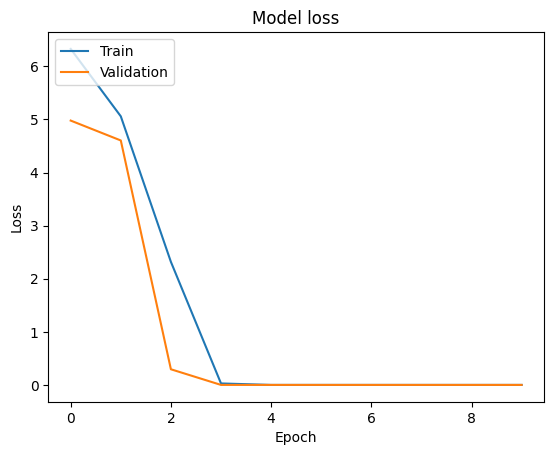

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Making prediction

In [ ]:

# make prediction
import tensorflow as tf
from tensorflow.keras.preprocessing import image

def return_img_tensor(path):
    img = image.load_img(path)
    img_array = image.img_to_array(img)
    img_tensor = tf.expand_dims(img_array, 0)
    return img_tensor

path = "test/12_05/0.png" # 12_05 is the image to predict
img_tensor = return_img_tensor(path)
print(img_tensor.shape)
prediction = model.predict(img_tensor)

(1, 400, 400, 3)
1/1 [==============================] - 0s 85ms/step


Prediction: 12:05


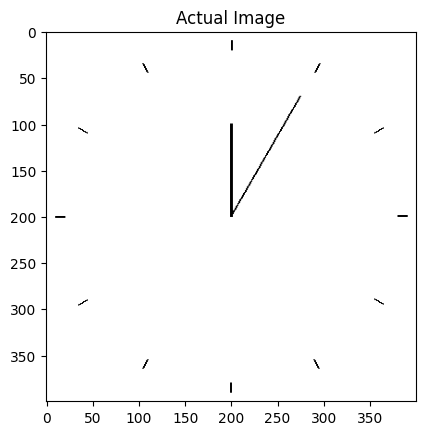

In [ ]:

# display prediction
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.imshow(mpimg.imread(path))
plt.title("Actual Image")
print("Prediction:", time_list[np.argmax(prediction)].replace('_',':'))